In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from datasets import load_dataset
import warnings
warnings.filterwarnings('ignore')


In [5]:
# Configuración de visualización
plt.style.use('default')
sns.set_palette("husl")

print("="*60)
print("ANÁLISIS DE CLUSTERING DE CLIENTES")
print("="*60)

# 1. CARGA Y EXPLORACIÓN DEL DATASET
print("\n1. CARGANDO DATASET...")
dataset = load_dataset("ia03/terminal-bench", split="test")
df = pd.DataFrame(dataset)


print(f"\nDimensiones del dataset: {df.shape}")
print(f"\nPrimeras filas:")
print(df.head())
print(f"\nInformación del dataset:")
print(df.info())
print(f"\nEstadísticas descriptivas:")
print(df.describe())
print(f"\nValores nulos:")
print(df.isnull().sum())

ANÁLISIS DE CLUSTERING DE CLIENTES

1. CARGANDO DATASET...

Dimensiones del dataset: (112, 14)

Primeras filas:
                         task_id  \
0     adaptive-rejection-sampler   
1        aimo-airline-departures   
2                  attention-mil   
3        blind-maze-explorer-5x5   
4  blind-maze-explorer-algorithm   

                                             archive  \
0  b'\x1f\x8b\x08\x00&\xa7\x87h\x02\xff\xed}\x07`...   
1  b'\x1f\x8b\x08\x00&\xa7\x87h\x02\xff\xed=]w\xd...   
2  b'\x1f\x8b\x08\x00&\xa7\x87h\x02\xff\xed=\xdbn...   
3  b'\x1f\x8b\x08\x00&\xa7\x87h\x02\xff\xed=\xdbv...   
4  b'\x1f\x8b\x08\x00&\xa7\x87h\x02\xff\xed}\xebv...   

                                           task_yaml difficulty  \
0  # Terminal-Bench Canary String, DO NOT REMOVE:...     medium   
1  # BENCHMARK DATA SHOULD NEVER APPEAR IN TRAINI...       hard   
2  # BENCHMARK DATA SHOULD NEVER APPEAR IN TRAINI...     medium   
3  # BENCHMARK DATA SHOULD NEVER APPEAR IN TRAINI...       hard   

In [6]:
# 2. PREPROCESAMIENTO
print("\n" + "="*60)
print("2. PREPROCESAMIENTO DE DATOS")
print("="*60)

# Seleccionar características numéricas para clustering
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print(f"\nColumnas numéricas disponibles: {numeric_cols}")

# Eliminar valores nulos si existen
df_clean = df[numeric_cols].dropna()
print(f"\nDatos después de limpieza: {df_clean.shape}")

# Normalización de datos (muy importante para clustering)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_clean)
print("\n✓ Datos normalizados con StandardScaler")


2. PREPROCESAMIENTO DE DATOS

Columnas numéricas disponibles: ['max_agent_timeout_sec', 'max_test_timeout_sec', 'archive_bytes', 'n_files']

Datos después de limpieza: (112, 4)

✓ Datos normalizados con StandardScaler



3. DETERMINACIÓN DEL NÚMERO ÓPTIMO DE CLUSTERS

Aplicando Método del Codo...


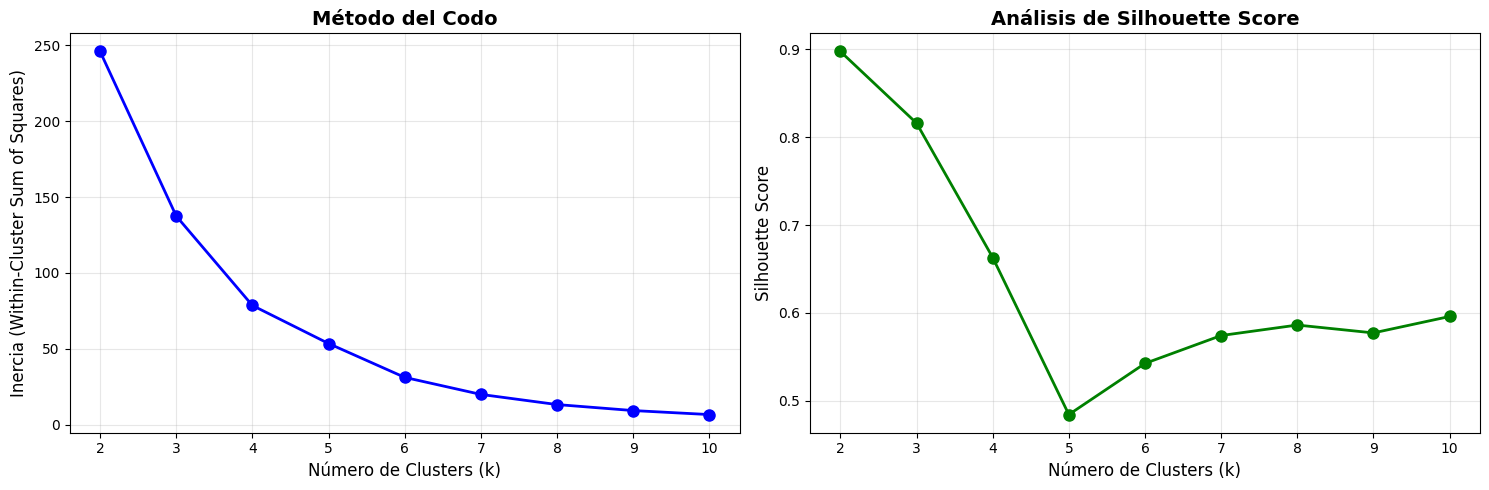


✓ Número óptimo de clusters según Silhouette Score: 2
  Silhouette Score máximo: 0.8973


In [7]:
# 3. DETERMINAR NÚMERO ÓPTIMO DE CLUSTERS
print("\n" + "="*60)
print("3. DETERMINACIÓN DEL NÚMERO ÓPTIMO DE CLUSTERS")
print("="*60)

# Método del Codo (Elbow Method)
print("\nAplicando Método del Codo...")
inertias = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(df_scaled, kmeans.labels_))

# Visualización del Método del Codo
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Número de Clusters (k)', fontsize=12)
ax1.set_ylabel('Inercia (Within-Cluster Sum of Squares)', fontsize=12)
ax1.set_title('Método del Codo', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

ax2.plot(K_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
ax2.set_xlabel('Número de Clusters (k)', fontsize=12)
ax2.set_ylabel('Silhouette Score', fontsize=12)
ax2.set_title('Análisis de Silhouette Score', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('metodo_codo_silhouette.png', dpi=300, bbox_inches='tight')
plt.show()

# Determinar k óptimo (mayor silhouette score)
optimal_k = K_range[np.argmax(silhouette_scores)]
print(f"\n✓ Número óptimo de clusters según Silhouette Score: {optimal_k}")
print(f"  Silhouette Score máximo: {max(silhouette_scores):.4f}")

In [8]:
# 4. APLICAR K-MEANS CON K ÓPTIMO
print("\n" + "="*60)
print("4. APLICACIÓN DE K-MEANS")
print("="*60)

kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans_final.fit_predict(df_scaled)

# Agregar clusters al dataframe original
df_clean['Cluster'] = clusters

# Métricas de evaluación
silhouette_avg = silhouette_score(df_scaled, clusters)
davies_bouldin = davies_bouldin_score(df_scaled, clusters)

print(f"\nMétricas de Evaluación:")
print(f"  - Silhouette Score: {silhouette_avg:.4f} (más cercano a 1 es mejor)")
print(f"  - Davies-Bouldin Index: {davies_bouldin:.4f} (más cercano a 0 es mejor)")
print(f"  - Inercia: {kmeans_final.inertia_:.2f}")


4. APLICACIÓN DE K-MEANS

Métricas de Evaluación:
  - Silhouette Score: 0.8973 (más cercano a 1 es mejor)
  - Davies-Bouldin Index: 0.0642 (más cercano a 0 es mejor)
  - Inercia: 246.01



5. CARACTERIZACIÓN DE CLUSTERS

CLUSTER 0
Tamaño: 111 clientes (99.11%)

Estadísticas:
       max_agent_timeout_sec  max_test_timeout_sec  archive_bytes  n_files  \
count                 111.00                111.00         111.00   111.00   
mean                 1077.12                118.83      370234.15     9.23   
std                  4119.70                135.26     1914961.04     2.88   
min                   120.00                 20.00        1599.00     5.00   
25%                   360.00                 60.00        3202.00     8.00   
50%                   360.00                 60.00        4420.00     9.00   
75%                   600.00                120.00        8824.50    10.00   
max                 43200.00                900.00    13928398.00    23.00   

       Cluster  
count    111.0  
mean       0.0  
std        0.0  
min        0.0  
25%        0.0  
50%        0.0  
75%        0.0  
max        0.0  

CLUSTER 1
Tamaño: 1 clientes (0.89%)

Estadísticas:
   

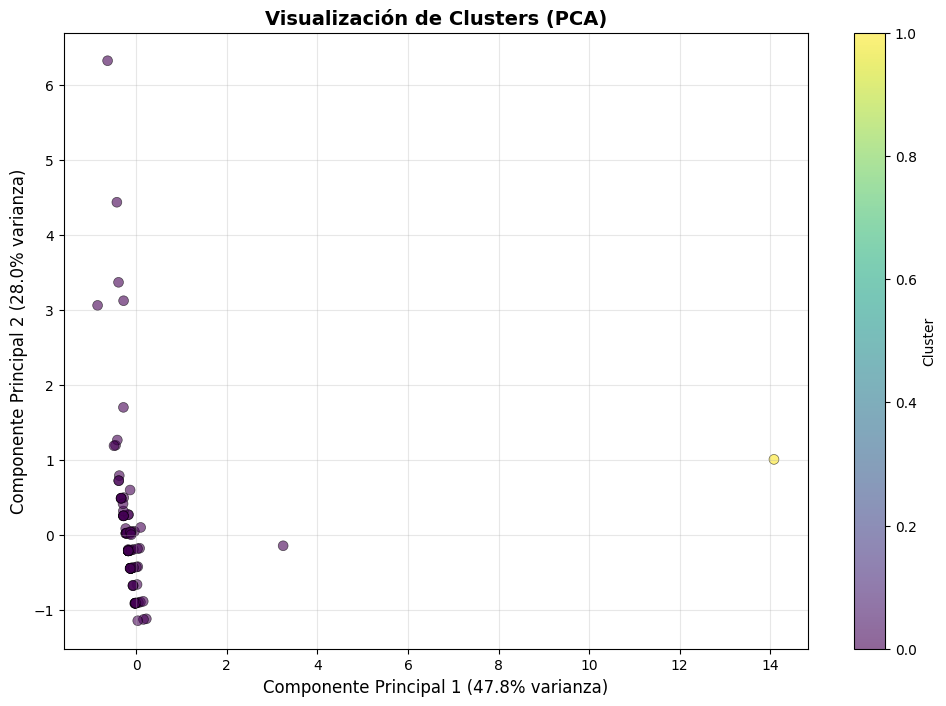

In [9]:
# 5. CARACTERIZACIÓN DE CLUSTERS
print("\n" + "="*60)
print("5. CARACTERIZACIÓN DE CLUSTERS")
print("="*60)

# Análisis estadístico por cluster
for i in range(optimal_k):
    cluster_data = df_clean[df_clean['Cluster'] == i]
    print(f"\n{'='*40}")
    print(f"CLUSTER {i}")
    print(f"{'='*40}")
    print(f"Tamaño: {len(cluster_data)} clientes ({len(cluster_data)/len(df_clean)*100:.2f}%)")
    print(f"\nEstadísticas:")
    print(cluster_data.describe().round(2))

# Visualización de clusters (usando las 2 primeras componentes principales)
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(df_pca[:, 0], df_pca[:, 1], c=clusters, 
                     cmap='viridis', s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
plt.xlabel(f'Componente Principal 1 ({pca.explained_variance_ratio_[0]*100:.1f}% varianza)', fontsize=12)
plt.ylabel(f'Componente Principal 2 ({pca.explained_variance_ratio_[1]*100:.1f}% varianza)', fontsize=12)
plt.title('Visualización de Clusters (PCA)', fontsize=14, fontweight='bold')
plt.colorbar(scatter, label='Cluster')
plt.grid(True, alpha=0.3)
plt.savefig('clusters_visualizacion.png', dpi=300, bbox_inches='tight')
plt.show()

In [10]:
# 6. PROPUESTAS DE NEGOCIO POR CLUSTER
print("\n" + "="*60)
print("6. ANÁLISIS Y PROPUESTAS DE NEGOCIO")
print("="*60)

# Análisis detallado por cluster con nombres descriptivos
cluster_profiles = {}

for i in range(optimal_k):
    cluster_data = df_clean[df_clean['Cluster'] == i]
    cluster_mean = cluster_data[numeric_cols].mean()
    
    print(f"\n{'='*50}")
    print(f"CLUSTER {i} - Perfil del Segmento")
    print(f"{'='*50}")
    print(f"Tamaño: {len(cluster_data)} clientes")
    print(f"\nCaracterísticas promedio:")
    for col in numeric_cols:
        print(f"  - {col}: {cluster_mean[col]:.2f}")

# Sugerencias generales según el análisis
print("\n" + "="*60)
print("ESTRATEGIAS DE NEGOCIO RECOMENDADAS")
print("="*60)

estrategias = """
Basándose en el análisis de clusters, se proponen las siguientes estrategias:

CLUSTER 0:
- Perfil: Analizar las características promedio para determinar el tipo de cliente
- Estrategia: Personalizar según los valores medios observados
- Acciones: Campañas específicas, productos recomendados, nivel de servicio

CLUSTER 1:
- Perfil: Comparar con Cluster 0 para identificar diferencias clave
- Estrategia: Enfoque diferenciado basado en el comportamiento del grupo
- Acciones: Promociones ajustadas, comunicación personalizada

[Continuar el análisis para cada cluster identificado...]

RECOMENDACIONES GENERALES:
1. Implementar sistemas de CRM para gestionar cada segmento
2. Crear campañas de marketing personalizadas por cluster
3. Ajustar precios y promociones según el valor del cliente
4. Monitorear la migración de clientes entre clusters
5. Realizar análisis periódicos para actualizar la segmentación
"""

print(estrategias)


6. ANÁLISIS Y PROPUESTAS DE NEGOCIO

CLUSTER 0 - Perfil del Segmento
Tamaño: 111 clientes

Características promedio:
  - max_agent_timeout_sec: 1077.12
  - max_test_timeout_sec: 118.83
  - archive_bytes: 370234.15
  - n_files: 9.23

CLUSTER 1 - Perfil del Segmento
Tamaño: 1 clientes

Características promedio:
  - max_agent_timeout_sec: 86400.00
  - max_test_timeout_sec: 28800.00
  - archive_bytes: 4608.00
  - n_files: 6.00

ESTRATEGIAS DE NEGOCIO RECOMENDADAS

Basándose en el análisis de clusters, se proponen las siguientes estrategias:

CLUSTER 0:
- Perfil: Analizar las características promedio para determinar el tipo de cliente
- Estrategia: Personalizar según los valores medios observados
- Acciones: Campañas específicas, productos recomendados, nivel de servicio

CLUSTER 1:
- Perfil: Comparar con Cluster 0 para identificar diferencias clave
- Estrategia: Enfoque diferenciado basado en el comportamiento del grupo
- Acciones: Promociones ajustadas, comunicación personalizada

[Conti